In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Paths for data.
Ravdess = "input/ravdess/audio_speech_actors_01-24/"
Crema = "input/Crema/"
Tess = "input/Tess/TESS Toronto emotional speech set data/"
Savee = "input/Savee/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

NotADirectoryError: [Errno 20] Not a directory: '/Users/manueldona/Kaggle/input/ravdess/audio_speech_actors_01-24/.DS_Store'

In [5]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  /Users/manueldona/Kaggle/input/Crema/1022_ITS_...
1    angry  /Users/manueldona/Kaggle/input/Crema/1037_ITS_...
2  neutral  /Users/manueldona/Kaggle/input/Crema/1060_ITS_...
3  neutral  /Users/manueldona/Kaggle/input/Crema/1075_ITS_...
4  disgust  /Users/manueldona/Kaggle/input/Crema/1073_IOM_...

In [6]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  disgust  /Users/manueldona/Kaggle/input/Tess/TESS Toron...
1  disgust  /Users/manueldona/Kaggle/input/Tess/TESS Toron...
2  disgust  /Users/manueldona/Kaggle/input/Tess/TESS Toron...
3  disgust  /Users/manueldona/Kaggle/input/Tess/TESS Toron...
4  disgust  /Users/manueldona/Kaggle/input/Tess/TESS Toron...

In [7]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                              Path
0       sad  /Users/manueldona/Kaggle/input/Savee/JK_sa01.wav
1       sad  /Users/manueldona/Kaggle/input/Savee/JK_sa15.wav
2   neutral   /Users/manueldona/Kaggle/input/Savee/DC_n13.wav
3  surprise  /Users/manueldona/Kaggle/input/Savee/DC_su09.wav
4   neutral   /Users/manueldona/Kaggle/input/Savee/DC_n07.wav

In [8]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    angry  /Users/manueldona/Kaggle/input/ravdess/audio_s...
1     fear  /Users/manueldona/Kaggle/input/ravdess/audio_s...
2     fear  /Users/manueldona/Kaggle/input/ravdess/audio_s...
3    angry  /Users/manueldona/Kaggle/input/ravdess/audio_s...
4  disgust  /Users/manueldona/Kaggle/input/ravdess/audio_s...

In [35]:
data_path.Emotions.value_counts()

angry       1923
fear        1923
disgust     1923
sad         1923
happy       1923
neutral     1703
surprise     652
calm         192
Name: Emotions, dtype: int64

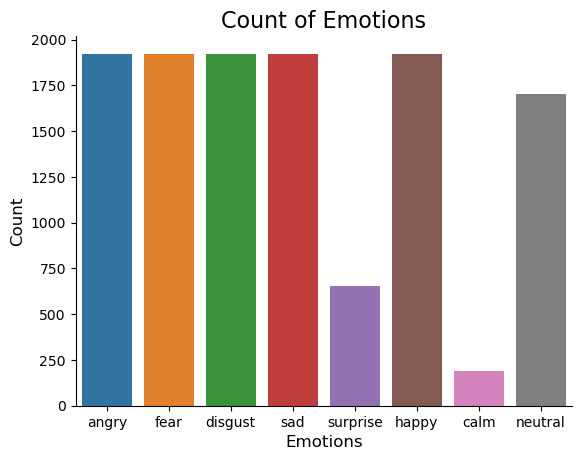

In [9]:
import matplotlib.pyplot as plt 
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [10]:
import librosa.display
import librosa

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

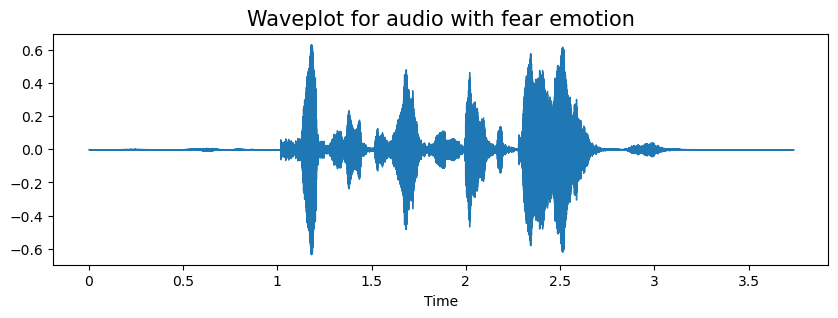

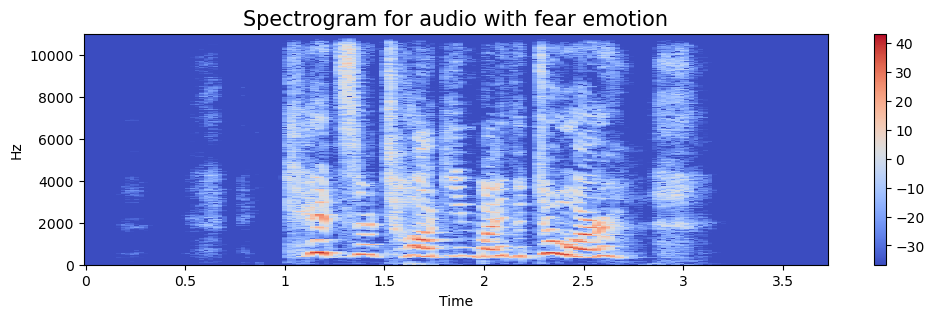

In [11]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

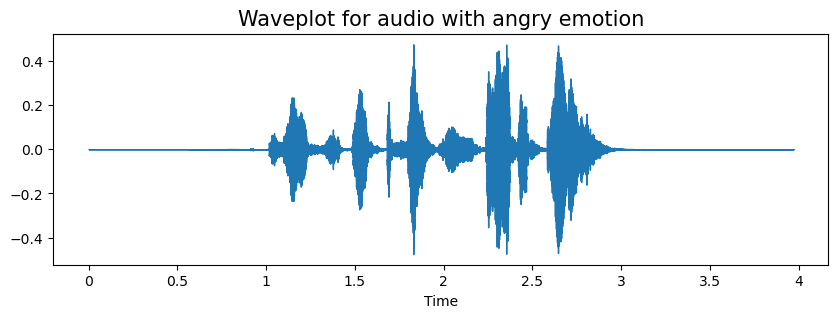

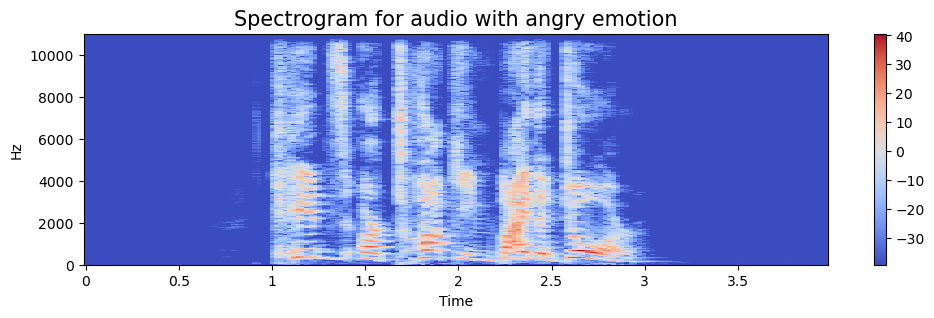

In [15]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

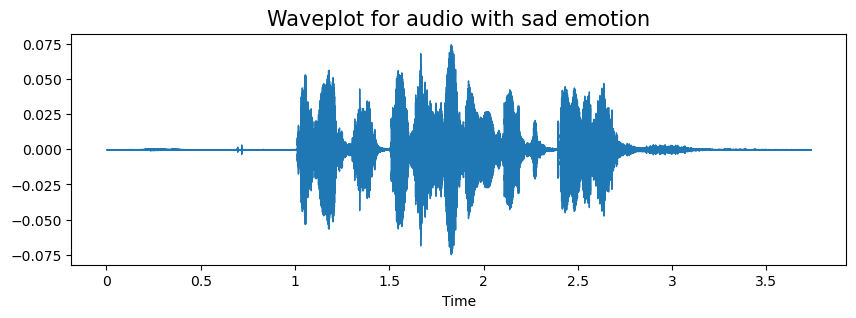

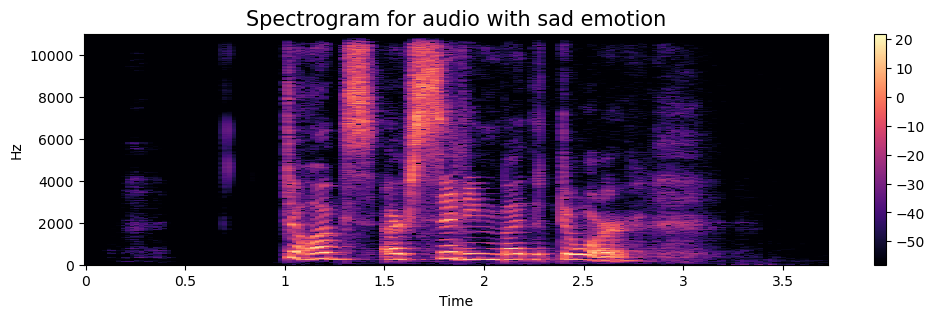

In [19]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

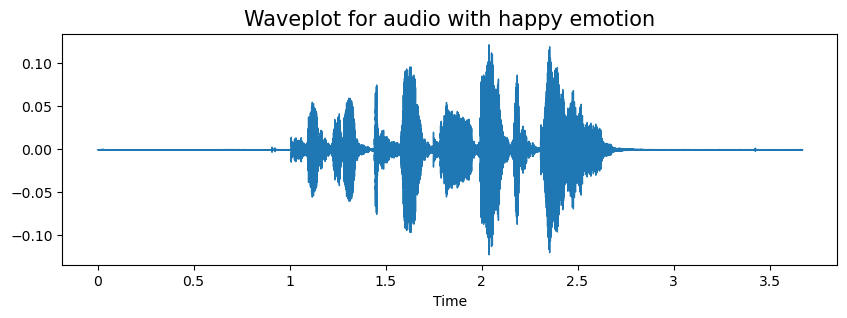

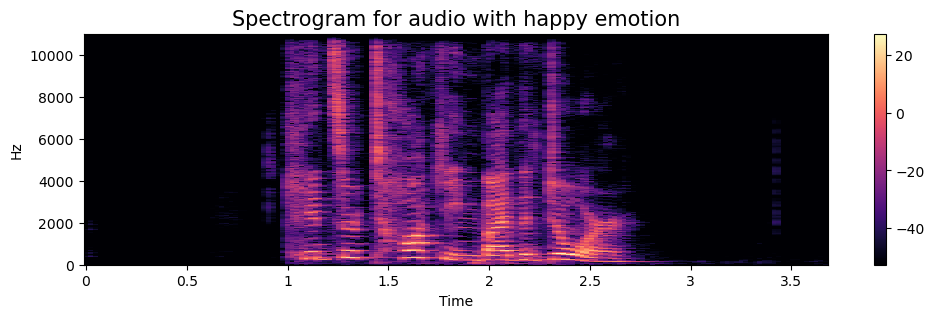

In [20]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [58]:
# Define the functions for each augmentation technique
def noise(data, noise_factor=0.005):
    noise_amp = noise_factor * np.random.uniform() * np.amax(data)
    noisy_data = data + noise_amp * np.random.normal(size=data.shape[0])
    return noisy_data

# Define the stretch function
def stretch(data, rate=0.9):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data, shift_range=2000):
    shift_amount = np.random.randint(low=-shift_range, high=shift_range)
    return np.roll(data, shift_amount)

# Define the pitch function
def pitch(data, sampling_rate, pitch_factor=0.0):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Load an audio file
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)


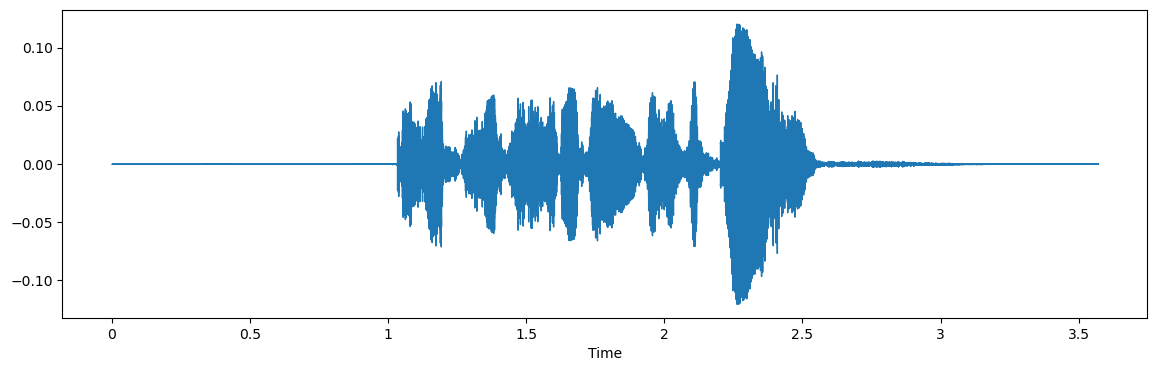

In [40]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

noise

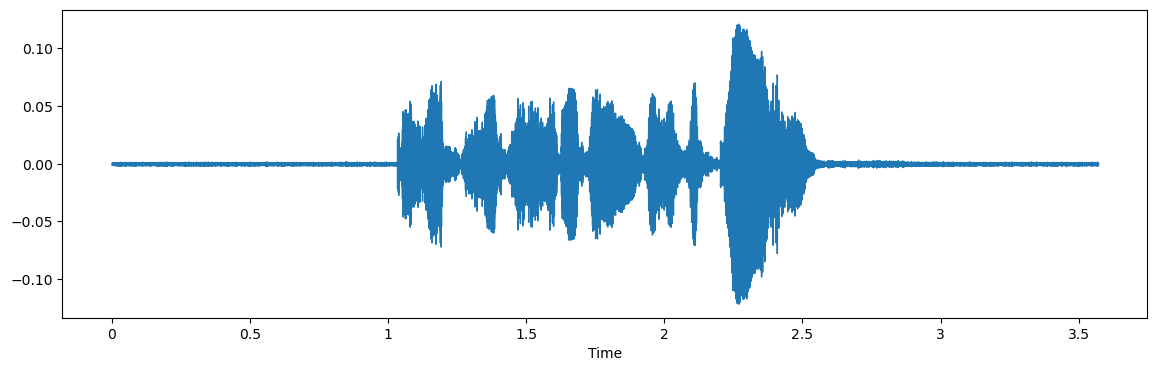

In [42]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

shift

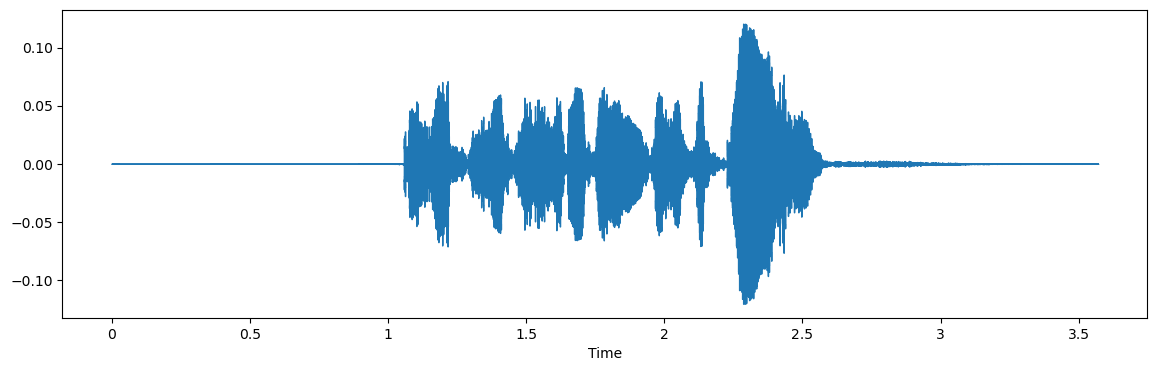

In [45]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

pitch

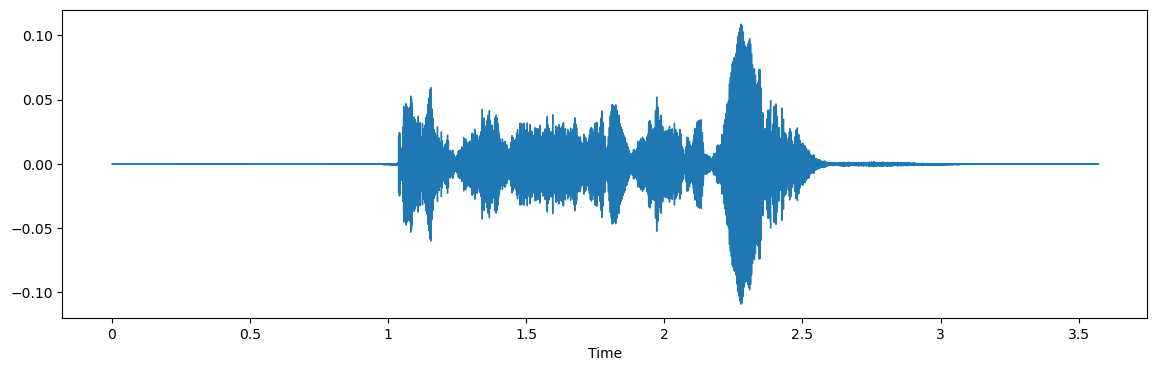

In [55]:
x = pitch(data, sample_rate, pitch_factor=0.6)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)


stretch

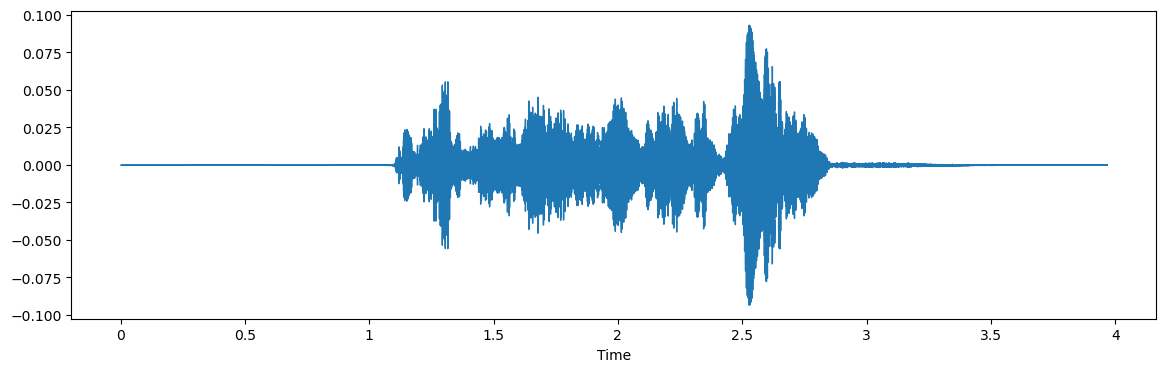

In [59]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

stretch + noise

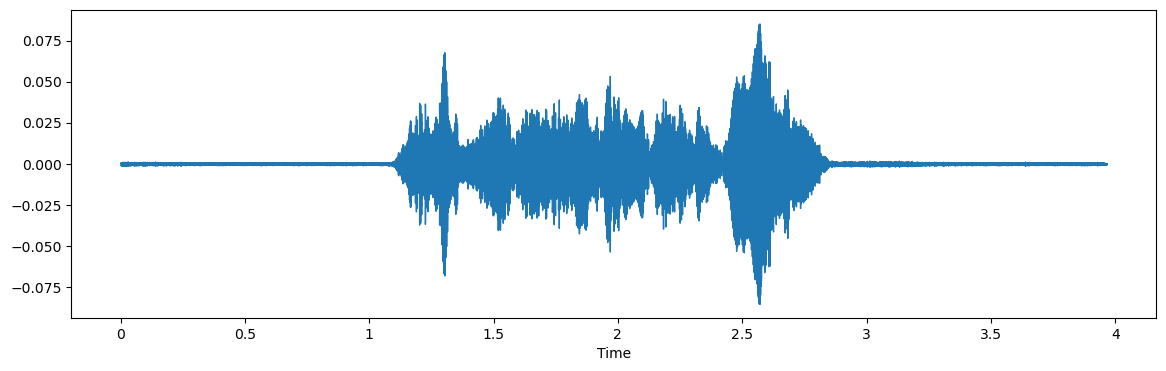

In [62]:
x = stretch(noise(data))
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

stretch + pitch

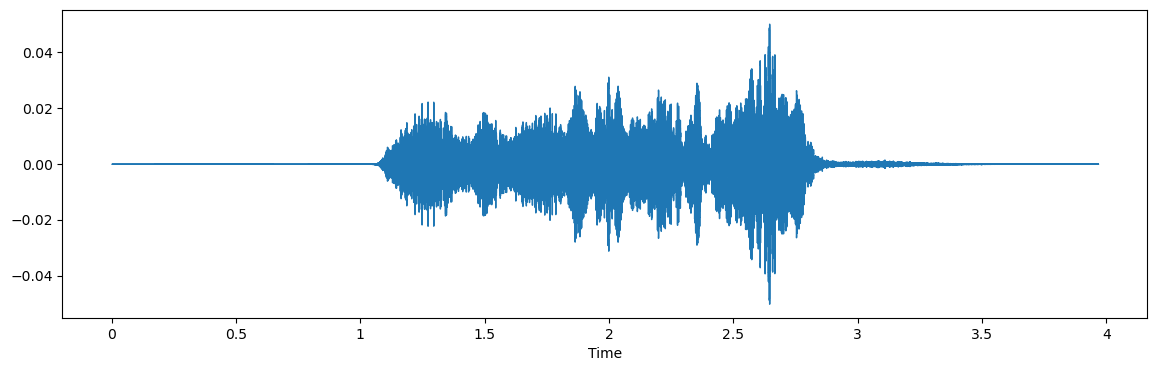

In [64]:
x = stretch(pitch(data, sample_rate, pitch_factor=0.4))
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [65]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [66]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [68]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.204540  0.519947  0.470245  0.491603  0.560526  0.548730  0.611754   
1  0.259978  0.603337  0.555927  0.574895  0.624116  0.600572  0.642393   
2  0.211060  0.542553  0.466062  0.481232  0.556774  0.541265  0.605234   
3  0.189815  0.559461  0.520419  0.483768  0.438286  0.392830  0.401268   
4  0.241152  0.647629  0.612619  0.581737  0.535081  0.522939  0.483836   

          7         8         9  ...       153       154       155       156  \
0  0.547266  0.531048  0.607427  ...  0.006682  0.004037  0.004855  0.004624   
1  0.587494  0.562767  0.636330  ...  0.006687  0.004033  0.004867  0.004665   
2  0.553066  0.529475  0.602934  ...  0.003468  0.002035  0.002439  0.001863   
3  0.409626  0.440601  0.506417  ...  0.002601  0.002952  0.003851  0.003154   
4  0.494315  0.532921  0.612519  ...  0.002605  0.002955  0.003855  0.003159   

        157       158       159       160       161  labels  
0  0.005723  0.006007  0.006103  0.005150  0.000251   angry  
1  0.005762  0.006029  0.006131  0.005192  0.000280   angry  
2  0.002751  0.003040  0.002424  0.002171  0.000148   angry  
3  0.002964  0.002586  0.002761  0.001653  0.000115    fear  
4  0.002966  0.002590  0.002763  0.001651  0.000115    fear  

[5 rows x 163 columns]

In [70]:
Features = pd.read_csv('features.csv')

In [71]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [72]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [73]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [74]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [75]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [60]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense, UpSampling1D, Add, Lambda, concatenate
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(x_train.shape[1], 1))

# Encoder
conv1 = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=5, strides=2, padding='same')(conv1)
dropout1 = Dropout(0.2)(pool1)
norm1 = BatchNormalization()(dropout1)

conv2 = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(norm1)  #norm1
pool2 = MaxPooling1D(pool_size=5, strides=3, padding='same')(conv2)
norm2 = BatchNormalization()(pool2)

# bottleneck
conv3 = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(norm2)
pool3 = MaxPooling1D(pool_size=5, strides=3, padding='same')(conv3)
norm3 = BatchNormalization()(pool3)

# Decoder

conv4 = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(norm3)
upsample1 = UpSampling1D(size=3)(conv4)
skip1 = concatenate([upsample1, norm2], axis=1)  # Concatenate along depth axis
norm4 = BatchNormalization()(skip1)

conv5 = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(norm4)
upsample2 = UpSampling1D(size=3)(conv5)
skip2 = concatenate([upsample2, norm1], axis=1)  # Concatenate along depth axis
dropout6 = Dropout(0.2)(skip2)
norm5 = BatchNormalization()(dropout6)

# Final Dense Layers
flatten = Flatten()(norm5)
dense1 = Dense(units=128, activation='relu')(flatten)
dropout_final = Dropout(0.3)(dense1)
norm_final = BatchNormalization()(dropout_final)
output_layer = Dense(units=8, activation='softmax')(norm_final)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 162, 1)]             0         []                            
                                                                                                  
 conv1d_58 (Conv1D)          (None, 162, 128)             768       ['input_17[0][0]']            
                                                                                                  
 max_pooling1d_46 (MaxPooli  (None, 81, 128)              0         ['conv1d_58[0][0]']           
 ng1D)                                                                                            
                                                                                                  
 dropout_20 (Dropout)        (None, 81, 128)              0         ['max_pooling1d_46[0][0]

In [61]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


2023-09-06 21:34:09.615538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - ETA: 0s - loss: 1.5043 - accuracy: 0.4392

2023-09-06 21:34:33.533062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - 27s 58ms/step - loss: 1.5043 - accuracy: 0.4392 - val_loss: 2.5215 - val_accuracy: 0.2846 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 24s 57ms/step - loss: 1.2356 - accuracy: 0.5212 - val_loss: 1.1706 - val_accuracy: 0.5545 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 23s 54ms/step - loss: 1.1275 - accuracy: 0.5592 - val_loss: 1.3646 - val_accuracy: 0.4153 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 23s 54ms/step - loss: 1.0674 - accuracy: 0.5810 - val_loss: 1.5903 - val_accuracy: 0.4696 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 23s 54ms/step - loss: 1.0258 - accuracy: 0.6009 - val_loss: 1.1629 - val_accuracy: 0.5277 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 23s 54ms/step - loss: 0.9841 - accuracy: 0.6174 - val_loss: 1.1439 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 23s 54ms/step -

In [15]:
model.save('unet.h5')

286/286 [==============================] - 4s 14ms/step - loss: 0.8259 - accuracy: 0.7920
Accuracy of our model on test data :  79.20412421226501 %


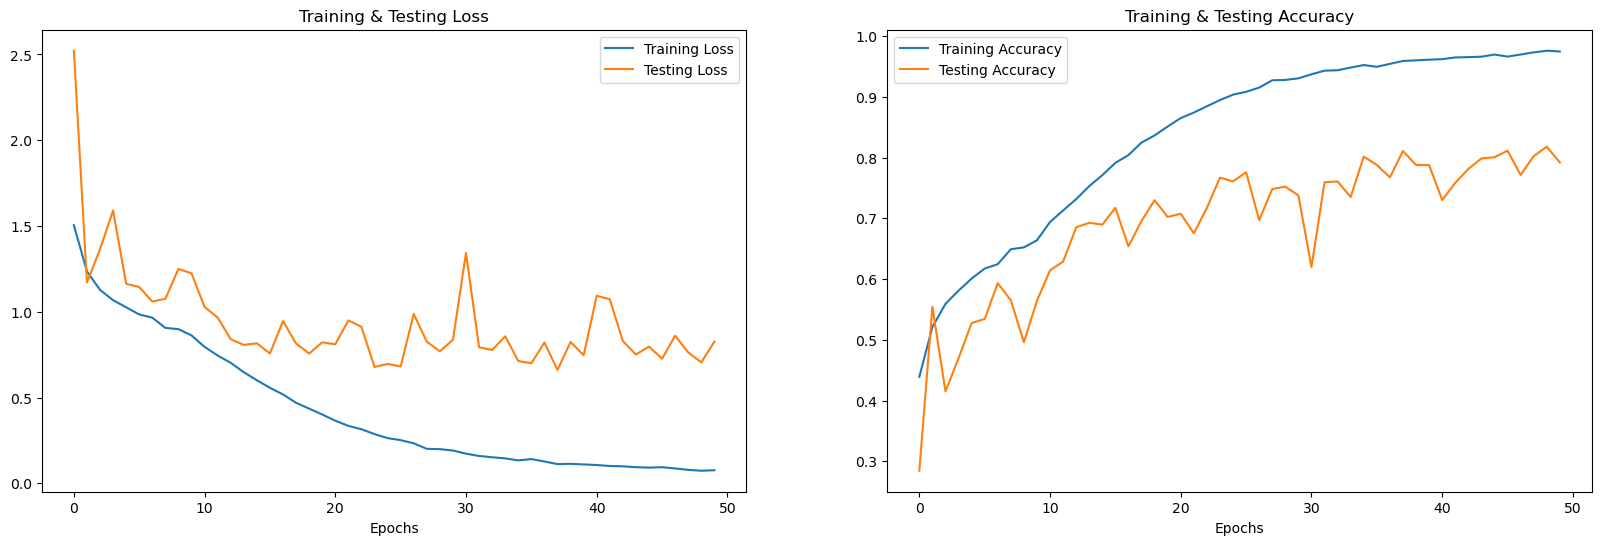

In [62]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [63]:
# predicting on test data.
pred_test = unet.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

2023-09-07 20:51:46.095956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 11s 38ms/step


In [12]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1         surprise      surprise
2          disgust       disgust
3            angry         angry
4              sad           sad
5            angry         happy
6             calm          calm
7              sad           sad
8              sad           sad
9         surprise      surprise

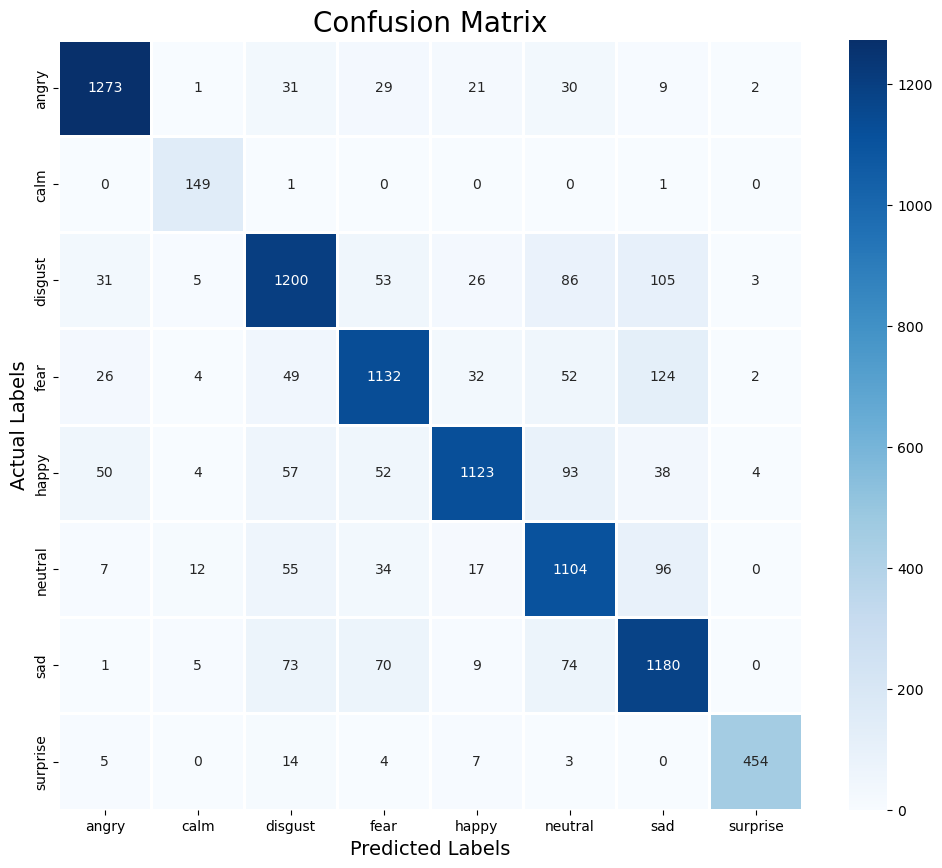

In [64]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.91      0.91      0.91      1396
        calm       0.83      0.99      0.90       151
     disgust       0.81      0.80      0.80      1509
        fear       0.82      0.80      0.81      1421
       happy       0.91      0.79      0.85      1421
     neutral       0.77      0.83      0.80      1325
         sad       0.76      0.84      0.80      1412
    surprise       0.98      0.93      0.95       487

    accuracy                           0.83      9122
   macro avg       0.85      0.86      0.85      9122
weighted avg       0.84      0.83      0.84      9122



Attention U-net

In [67]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense, UpSampling1D, Add, Lambda, concatenate, Activation, LayerNormalization
from tensorflow.keras.models import Model

In [76]:


def attention_gate(g, s, num_filters, strides, upsample_size):
    Wg = Conv1D(num_filters, 1, padding="same", strides=1)(g)
    Wg = LayerNormalization()(Wg)

    Ws = Conv1D(num_filters, 1, padding="same", strides=strides)(s)
    Ws = BatchNormalization()(Ws)
    
    out = Activation("relu")(Wg + Ws)
    out = Conv1D(1, 1, padding="same")(out)
    out = Activation("sigmoid")(out)
    out = UpSampling1D(size=upsample_size)(out)
    mult = out * s
    result = Conv1D(s.shape[2], 1, padding='same')(mult)
    result_bn = BatchNormalization()(result)
    return result_bn

# Define the input layer
input_layer = Input(shape=(x_train.shape[1], 1))


conv2 = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(input_layer)  # norm1
pool2 = MaxPooling1D(pool_size=5, strides=2, padding='same')(conv2)
dropout1 = Dropout(0.2)(pool2)
norm2 = BatchNormalization()(dropout1)

conv3 = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(norm2)
pool3 = MaxPooling1D(pool_size=5, strides=3, padding='same')(conv3)
norm3 = BatchNormalization()(pool3)

conv4 = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(norm3)
norm4 = BatchNormalization()(conv4)

# attention:  g comes from norm4 (the lowest layer) and x comes from conv3, the previous conv layer
att1 = attention_gate(g=norm4, s=conv3, num_filters=256, strides=3, upsample_size=3)
# concat att1 with upsampled norm4
upsample1 = UpSampling1D(size=3)(norm4)
concat1 = concatenate([att1, upsample1], axis=2)

conv5 = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(concat1)
norm5 = BatchNormalization()(conv5)

# attention
att2 = attention_gate(g=norm5, s=conv2, num_filters=128, strides=2, upsample_size=2)
# concat
upsample2 = UpSampling1D(size=2)(norm5)
concat2 = concatenate([att2, upsample2], axis=2)

conv6 = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(concat2)
dropout2 = Dropout(0.2)(conv6)
norm6 = BatchNormalization()(dropout2)

# Final Dense Layers
flatten = Flatten()(norm6)
dense1 = Dense(units=128, activation='relu')(flatten)
dropout_final = Dropout(0.3)(dense1)
norm_final = BatchNormalization()(dropout_final)
output_layer = Dense(units=8, activation='softmax')(norm_final)

# Create the model
attention_unet = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
attention_unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

attention_unet.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 162, 1)]             0         []                            
                                                                                                  
 conv1d_76 (Conv1D)          (None, 162, 128)             768       ['input_19[0][0]']            
                                                                                                  
 max_pooling1d_51 (MaxPooli  (None, 81, 128)              0         ['conv1d_76[0][0]']           
 ng1D)                                                                                            
                                                                                                  
 dropout_26 (Dropout)        (None, 81, 128)              0         ['max_pooling1d_51[0][0]

In [199]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=attention_unet.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


2023-08-12 20:49:14.266425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - ETA: 0s - loss: 1.3348 - accuracy: 0.5018

2023-08-12 20:50:35.058798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - 92s 189ms/step - loss: 1.3348 - accuracy: 0.5018 - val_loss: 2.0646 - val_accuracy: 0.2850 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 65s 152ms/step - loss: 1.0878 - accuracy: 0.5754 - val_loss: 1.0466 - val_accuracy: 0.5855 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 65s 152ms/step - loss: 0.9824 - accuracy: 0.6213 - val_loss: 1.2539 - val_accuracy: 0.5535 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 73s 171ms/step - loss: 0.9074 - accuracy: 0.6532 - val_loss: 0.9722 - val_accuracy: 0.6074 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 73s 171ms/step - loss: 0.8194 - accuracy: 0.6846 - val_loss: 0.8700 - val_accuracy: 0.6572 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 75s 175ms/step - loss: 0.7512 - accuracy: 0.7154 - val_loss: 0.8129 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 71s 167ms

286/286 [==============================] - 8s 26ms/step - loss: 0.4848 - accuracy: 0.9010
Accuracy of our model on test data :  90.10085463523865 %


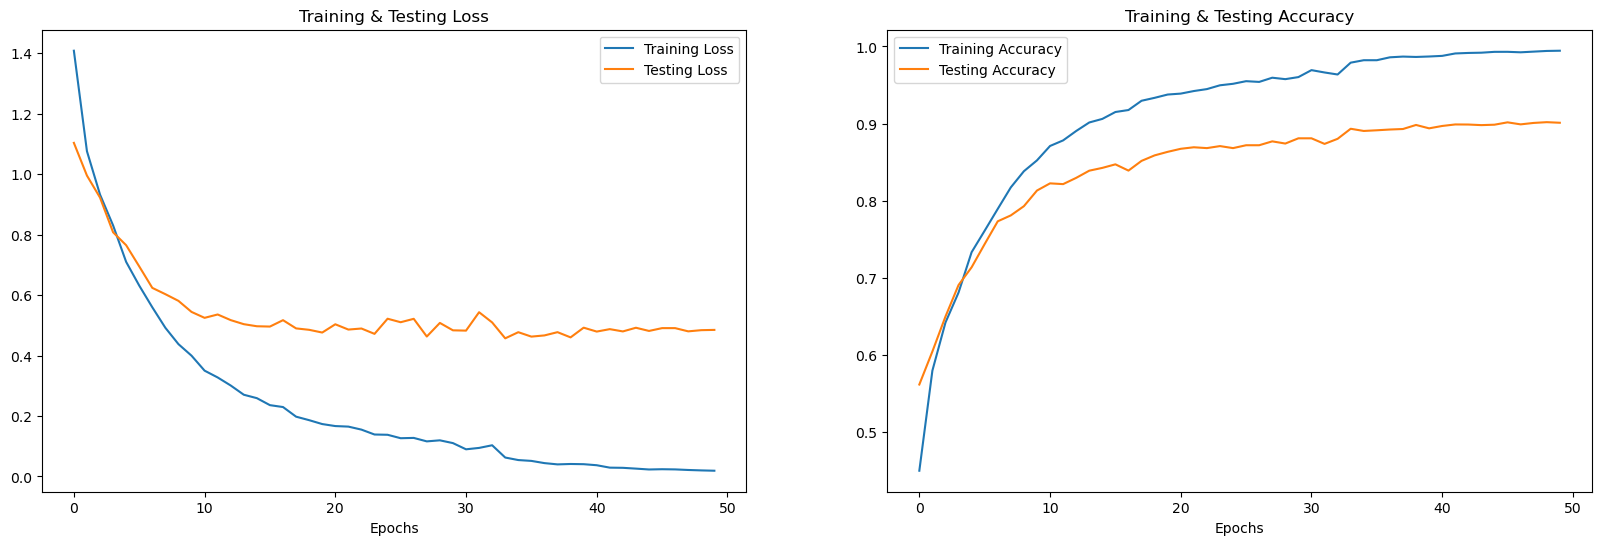

In [78]:
print("Accuracy of our model on test data : " , attention_unet.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [22]:
# predicting on test data.
pred_test = attention_unet.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

2023-09-06 21:14:35.746011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


286/286 [==============================] - 7s 22ms/step


In [23]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

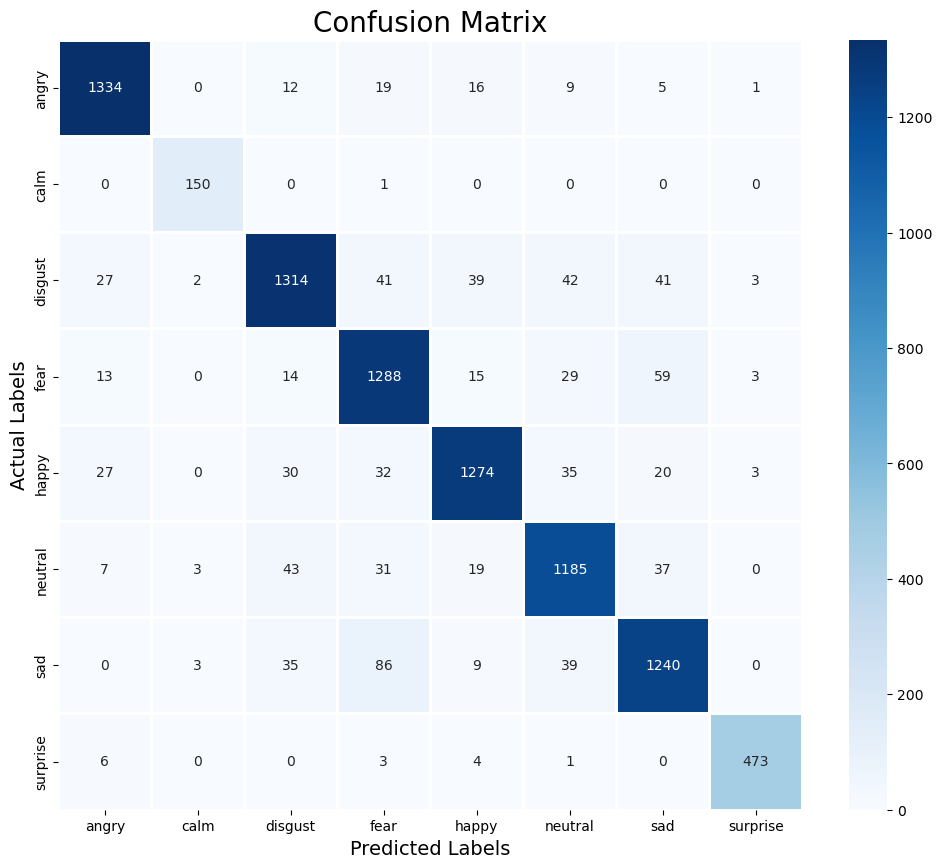

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.94      0.96      0.95      1396
        calm       0.95      0.99      0.97       151
     disgust       0.91      0.87      0.89      1509
        fear       0.86      0.91      0.88      1421
       happy       0.93      0.90      0.91      1421
     neutral       0.88      0.89      0.89      1325
         sad       0.88      0.88      0.88      1412
    surprise       0.98      0.97      0.98       487

    accuracy                           0.91      9122
   macro avg       0.92      0.92      0.92      9122
weighted avg       0.91      0.91      0.91      9122



In [137]:
attention_unet.save('attention_unet.h5')